# Prophet

In [ ]:
# import packages

import pandas as pd
import numpy as np
from fbprophet import Prophet

In [ ]:
Prophet?

## Steel

In [ ]:
# import steel production

df_prod = pd.read_csv('../data/raw/Industry/SteelHistorical_datetime.csv')
df_prod.head()

In [ ]:
df_prod.tail()

In [ ]:
df_macro = pd.read_csv('../data/raw/Industry/MacroHistorical_datetime.csv')

In [ ]:
df_macro.head()

In [ ]:
df_macro.tail()

In [ ]:
# create per capita

df_macro['GDP_per_capita'] = df_macro['GDP'].div(df_macro['Population'])

In [ ]:
# merge dataframes

df = pd.merge(df_prod,df_macro,how='left',on=['Economy','Year'])

In [ ]:
# Select AUS
df = df.set_index('Economy')
df = df.loc['AUS']

In [ ]:
# make Year ds and use only AUS
df =df.reset_index()
df.head()

In [ ]:
df.tail()

In [ ]:
# create natural log of production per capita as a feature

df['ln_prod_per_cap'] = df['SteelConsumption'].div(df['Population'])
df['ln_prod_per_cap'] = np.log(df['ln_prod_per_cap'])

df['ln_GDP_per_cap'] = np.log(df['GDP_per_capita'])

df.head()

In [ ]:
df = df.rename(columns={"Economy": "e", "Year": "ds","ln_prod_per_cap":"y"})
df.head()

In [ ]:
m = Prophet(daily_seasonality=False,
            weekly_seasonality=False,
            yearly_seasonality=False,
            seasonality_mode='multiplicative',
            growth='linear')

m.add_regressor('ln_GDP_per_cap')
m.fit(df)

In [ ]:
# add future GDP

df_future_macro = pd.read_csv('../data/raw/Industry/MacroAssumptions_datetime.csv')
df_future_macro.head()

In [ ]:
# create per capita

df_future_macro['GDP_per_capita'] = df_future_macro['GDP'].div(df_future_macro['Population'])

In [ ]:
# select only AUS

df_future_macro = df_future_macro.set_index('Economy')
df_future_macro = df_future_macro.loc['AUS']
df_future_macro = df_future_macro.reset_index()
df_future_macro.tail()

In [ ]:
# create natural log of GDP per capita
df_future_macro['ln_GDP_per_cap'] = np.log(df_future_macro['GDP_per_capita'])
df_future_macro.head()

In [ ]:
# extract GDP_per_capita for 1980-2050

df1 = pd.DataFrame(columns = ['ln_GDP_per_cap'])
df2 = pd.DataFrame(columns = ['ln_GDP_per_cap'])

df1['ln_GDP_per_cap'] = df['ln_GDP_per_cap']
df2['ln_GDP_per_cap'] = df_future_macro['ln_GDP_per_cap']
#df1 = df['GDP_per_capita']
#df2 = df_future_macro['GDP_per_capita']

In [ ]:
df2.info()

In [ ]:
df_future = pd.concat([df1,df2],
                     ignore_index=True)

In [ ]:
df_future.info()

In [ ]:
m.make_future_dataframe?

In [ ]:
future = m.make_future_dataframe(periods=34,
                                 freq = 'Y',
                                 include_history=True)
future.head()

In [ ]:
future.tail()

In [ ]:
future['ln_GDP_per_cap']=df_future['ln_GDP_per_cap']

In [ ]:
future.head()

In [ ]:
future.tail()

In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
fig1 = m.plot(forecast)

# Use Own Function with SciKit-Learn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [ ]:
def run_regression(models, economies, df, x, y):
    """
    Perform linear regression for one or multiple economies.
    economy = list of economies
    models = {economy: LinearRegression() for economy in economies}
    The function returns a dictionary of economy-model pairs. That is,
    each economy will have its own set of coefficients.
    """
    for economy, model in models.items():
            (model.fit(df.loc[economy, x],
                df.loc[economy, y]))
    return models  

In [ ]:
def run_prediction(models, economies, df):
    """
    Use coefficients from run_regression to generate predictions.
    Pass a dataframe df with the X and Y data. 
    ResultsColumn = name of prediction results
    """
    df_list =[]
    # run predictions
    for economy, model in models.items():
            # make prediction
            prediction = model.predict(df.loc[economy,:])
            
            # adding to the input df
            df2 = df.loc[economy,:]
            df2.insert(loc=0,column="Results",value=prediction)
            df2.insert(loc=0,column='Economy',value=economy)
            df2 = df2.reset_index()
            df2 = df2.set_index(['Economy','Year'])
            df_list.append(df2)

    # combine individual economy dataframes to one dataframe
    dfResults = pd.concat(df_list, sort=True)
    return dfResults

### import steel production

In [ ]:
df_prod = pd.read_csv('../data/raw/Industry/SteelHistorical.csv',
                     index_col=['Economy','Year'])
df_prod.head()

In [ ]:
df_macro = pd.read_csv('../data/raw/Industry/MacroHistorical.csv',
                      index_col=['Economy','Year'])
df_macro.head()

### create features

In [ ]:
df_macro['GDP_per_capita'] = df_macro['GDP'].div(df_macro['Population'])

In [ ]:
df = pd.merge(df_prod,df_macro,how='left',on=['Economy','Year'])

In [ ]:
df['ln_prod_per_cap'] = df['SteelConsumption'].div(df['Population'])
df['ln_prod_per_cap'] = np.log(df['ln_prod_per_cap'])

df['ln_GDP_per_cap'] = np.log(df['GDP_per_capita'])

df.head()

In [ ]:
economies = df.index.unique(level=0)
economies

In [ ]:
models = {economy: LinearRegression(fit_intercept=True) for economy in economies}

In [ ]:
x = ['ln_GDP_per_cap']
y = ['ln_prod_per_cap']

In [ ]:
run_regression(models,economies,df,x,y)

### make predictions

In [ ]:
df_future_macro = pd.read_csv('../data/raw/Industry/MacroAssumptions.csv',
                             index_col=['Economy','Year'])
df_future_macro['GDP_per_capita'] = df_future_macro['GDP'].div(df_future_macro['Population'])
df_future_macro.head()

In [ ]:
df_future_macro['ln_GDP_per_cap'] = np.log(df_future_macro['GDP_per_capita'])
df2 = df_future_macro.drop(['GDP', 'Population','GDP_per_capita'], axis=1)
df2.head()

In [ ]:
results = run_prediction(models, economies, df2)
results = results.rename(columns={"Results":"ln_steel_consumption"})
results.head()

### plot results

In [ ]:
x = results.loc['AUS']
x.head()

In [ ]:
fig, ax = plt.subplots()
ax.plot(x.index,x[['ln_steel_consumption']], 'o', label="Predictions")

# Prophet for all economies

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from pandas.tseries.offsets import MonthEnd

### read in historical data

In [2]:
df_prod = pd.read_csv('../data/raw/Industry/SteelHistorical.csv')
df_prod.head()

,Economy,Year,SteelConsumption
0,AUS,1990,5511000
1,AUS,1991,5294000
2,AUS,1992,5120000
3,AUS,1993,5757000
4,AUS,1994,6326000


### Make year column YYYY-MM-DD format for Prophet

In [3]:
df_prod['ds']=pd.to_datetime(df_prod['Year'],format='%Y')
df_prod.head()

,Economy,Year,SteelConsumption,ds
0,AUS,1990,5511000,1990-01-01
1,AUS,1991,5294000,1991-01-01
2,AUS,1992,5120000,1992-01-01
3,AUS,1993,5757000,1993-01-01
4,AUS,1994,6326000,1994-01-01


In [4]:
df_prod = df_prod.set_index(['Economy'])
df_prod.head()

,Year,SteelConsumption,ds
Economy,,,
AUS,1990,5511000,1990-01-01
AUS,1991,5294000,1991-01-01
AUS,1992,5120000,1992-01-01
AUS,1993,5757000,1993-01-01
AUS,1994,6326000,1994-01-01


In [5]:
df_prod['ds'] = pd.to_datetime(df_prod['ds'], format="%Y%m") + MonthEnd(12)
df_prod.head()

,Year,SteelConsumption,ds
Economy,,,
AUS,1990,5511000,1990-12-31
AUS,1991,5294000,1991-12-31
AUS,1992,5120000,1992-12-31
AUS,1993,5757000,1993-12-31
AUS,1994,6326000,1994-12-31


### read in historical macro data

In [6]:
df_macro = pd.read_csv('../data/raw/Industry/MacroHistorical.csv')
df_macro.head()

,Economy,Year,GDP,Population
0,AUS,1990,515.317626,17.042
1,AUS,1991,513.320531,17.272
2,AUS,1992,515.592569,17.486
3,AUS,1993,536.417759,17.688
4,AUS,1994,557.759322,17.883


In [7]:
df_macro['ds']=pd.to_datetime(df_macro['Year'],format='%Y')
df_macro['ds'] = pd.to_datetime(df_macro['ds'], format="%Y%m") + MonthEnd(12)
df_macro = df_macro.set_index(['Economy'])
df_macro.head()

,Year,GDP,Population,ds
Economy,,,,
AUS,1990,515.317626,17.042,1990-12-31
AUS,1991,513.320531,17.272,1991-12-31
AUS,1992,515.592569,17.486,1992-12-31
AUS,1993,536.417759,17.688,1993-12-31
AUS,1994,557.759322,17.883,1994-12-31


In [8]:
df_macro['GDP_per_capita'] = df_macro['GDP'].div(df_macro['Population'])
df = pd.merge(df_prod,df_macro,how='left',on=['Economy','ds','Year'])

In [9]:
df.head()

,Year,SteelConsumption,ds,GDP,Population,GDP_per_capita
Economy,,,,,,
AUS,1990,5511000,1990-12-31,515.317626,17.042,30.238096
AUS,1991,5294000,1991-12-31,513.320531,17.272,29.719808
AUS,1992,5120000,1992-12-31,515.592569,17.486,29.486021
AUS,1993,5757000,1993-12-31,536.417759,17.688,30.326649
AUS,1994,6326000,1994-12-31,557.759322,17.883,31.189360


### create features

In [10]:
df['ln_prod_per_cap'] = df['SteelConsumption'].div(df['Population'])
df['ln_prod_per_cap'] = np.log(df['ln_prod_per_cap'])

df['ln_GDP_per_cap'] = np.log(df['GDP_per_capita'])

df = df.rename(columns={"ln_prod_per_cap":"y"})

df.head()

,Year,SteelConsumption,ds,GDP,Population,GDP_per_capita,y,ln_GDP_per_cap
Economy,,,,,,,,
AUS,1990,5511000,1990-12-31,515.317626,17.042,30.238096,12.686576,3.409103
AUS,1991,5294000,1991-12-31,513.320531,17.272,29.719808,12.632998,3.391814
AUS,1992,5120000,1992-12-31,515.592569,17.486,29.486021,12.587264,3.383916
AUS,1993,5757000,1993-12-31,536.417759,17.688,30.326649,12.693041,3.412027
AUS,1994,6326000,1994-12-31,557.759322,17.883,31.189360,12.776328,3.440077


In [11]:
economies = df.index.unique()
economies

Index(['AUS', 'BD', 'CDA', 'CHL', 'PRC', 'HKC', 'INA', 'JPN', 'KOR', 'MAS',
       'MEX', 'NZ', 'PNG', 'PE', 'RP', 'RUS', 'SIN', 'CT', 'THA', 'USA', 'VN'],
      dtype='object', name='Economy')

In [ ]:
#models={}


models = {economy: Prophet(daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False,
                   seasonality_mode='additive',
                   growth='linear').add_regressor('ln_GDP_per_cap')
          for economy in economies}

In [12]:
models ={}
for economy in economies:
    m = Prophet(daily_seasonality=False,
                   weekly_seasonality=False,
                   yearly_seasonality=False,
                   seasonality_mode='additive',
                   growth='linear')
    m.add_regressor('ln_GDP_per_cap')
    models[economy] = m
models

{'AUS': <fbprophet.forecaster.Prophet at 0x1fb59aa37c8>,
 'BD': <fbprophet.forecaster.Prophet at 0x1fb59aa3f08>,
 'CDA': <fbprophet.forecaster.Prophet at 0x1fb59aa3f88>,
 'CHL': <fbprophet.forecaster.Prophet at 0x1fb59aa3a88>,
 'PRC': <fbprophet.forecaster.Prophet at 0x1fb59aa3d48>,
 'HKC': <fbprophet.forecaster.Prophet at 0x1fb59aa3ec8>,
 'INA': <fbprophet.forecaster.Prophet at 0x1fb59aa3188>,
 'JPN': <fbprophet.forecaster.Prophet at 0x1fb59aa3608>,
 'KOR': <fbprophet.forecaster.Prophet at 0x1fb59aa3dc8>,
 'MAS': <fbprophet.forecaster.Prophet at 0x1fb59aa33c8>,
 'MEX': <fbprophet.forecaster.Prophet at 0x1fb59aa3848>,
 'NZ': <fbprophet.forecaster.Prophet at 0x1fb59aa3e08>,
 'PNG': <fbprophet.forecaster.Prophet at 0x1fb59aa3d88>,
 'PE': <fbprophet.forecaster.Prophet at 0x1fb59aa3c48>,
 'RP': <fbprophet.forecaster.Prophet at 0x1fb59aa3f48>,
 'RUS': <fbprophet.forecaster.Prophet at 0x1fb59aa3988>,
 'SIN': <fbprophet.forecaster.Prophet at 0x1fb59aa3908>,
 'CT': <fbprophet.forecaster.Prophe

In [13]:
for economy,model in models.items():
    model.fit(df.loc[economy])  

INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.
INFO:fbproph

### add future assumptions

In [14]:
df_future_macro = pd.read_csv('../data/raw/Industry/MacroAssumptions.csv',
                             index_col=['Economy'])
df_future_macro['GDP_per_capita'] = df_future_macro['GDP'].div(df_future_macro['Population'])
df_future_macro['ln_GDP_per_cap'] = np.log(df_future_macro['GDP_per_capita'])
df_future_macro.head()

,Year,GDP,Population,GDP_per_capita,ln_GDP_per_cap
Economy,,,,,
AUS,2017,1157.283926,24.451,47.330740,3.857160
AUS,2018,1201.142573,24.772,48.487913,3.881315
AUS,2019,1245.039044,25.089,49.624897,3.904493
AUS,2020,1289.224526,25.398,50.760868,3.927126
AUS,2021,1333.639686,25.700,51.892595,3.949176


In [15]:
df_future_macro['ds'] = pd.to_datetime(df_future_macro['Year'],format='%Y')
df_future_macro['ds'] = pd.to_datetime(df_future_macro['ds'], format="%Y%m") + MonthEnd(12)
df_future_macro.head()

,Year,GDP,Population,GDP_per_capita,ln_GDP_per_cap,ds
Economy,,,,,,
AUS,2017,1157.283926,24.451,47.330740,3.857160,2017-12-31
AUS,2018,1201.142573,24.772,48.487913,3.881315,2018-12-31
AUS,2019,1245.039044,25.089,49.624897,3.904493,2019-12-31
AUS,2020,1289.224526,25.398,50.760868,3.927126,2020-12-31
AUS,2021,1333.639686,25.700,51.892595,3.949176,2021-12-31


In [16]:
df_future_macro.tail()

,Year,GDP,Population,GDP_per_capita,ln_GDP_per_cap,ds
Economy,,,,,,
VN,2046,2411.704114,113.481,21.252052,3.056453,2046-12-31
VN,2047,2502.285597,113.800,21.988450,3.090517,2047-12-31
VN,2048,2594.447303,114.099,22.738563,3.124062,2048-12-31
VN,2049,2688.477582,114.376,23.505609,3.157239,2049-12-31
VN,2050,2784.627331,114.630,24.292309,3.190160,2050-12-31


In [ ]:
fut_list =[]
for economy in economies:
    fut = m.make_future_dataframe(periods=34,
                                 freq = 'Y',
                                 include_history=True)
    fut.insert(loc=0,column='Economy',value=economy)
    fut = fut.set_index(['Economy'])
    fut_list.append(fut)
future = pd.concat(fut_list)

In [ ]:
future

In [17]:
# add regressors for 1990-2050

regressors_hist = df.drop(columns=['Year','SteelConsumption','GDP','Population','GDP_per_capita','y'])
regressors_fut = df_future_macro.drop(columns=['Year','GDP','Population','GDP_per_capita'])
_regressors_list =[]

for economy in economies:
    _regressors = pd.concat([regressors_hist.loc[economy],regressors_fut.loc[economy]],
                      ignore_index=False, sort=False)
    _regressors_list.append(_regressors)
regressors = pd.concat(_regressors_list)

In [ ]:
regressors.to_csv ('../data/final/regressors.csv', header=True)

In [ ]:
df_future_macro.info()

In [ ]:
df.info()

### run prediction

In [18]:
pred_list =[]
for economy,model in models.items():
    forecast = model.predict(regressors.loc[economy])
    forecast.insert(loc=0,column='Economy',value=economy)
    forecast = forecast.set_index(['Economy'])
    pred_list.append(forecast)
results = pd.concat(pred_list, sort=False)

In [19]:
results[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
Economy,,,,
AUS,1990-12-31,12.678504,12.586304,12.765630
AUS,1991-12-31,12.664264,12.582712,12.760532
AUS,1992-12-31,12.657622,12.568962,12.736188
AUS,1993-12-31,12.680113,12.593377,12.767767
AUS,1994-12-31,12.702556,12.615274,12.786360
...,...,...,...,...
VN,2046-12-31,14.087016,13.306692,14.876884
VN,2047-12-31,14.113057,13.323498,14.939962
VN,2048-12-31,14.136451,13.262397,15.006050


C:\Users\david\Anaconda3\envs\env2\lib\site-packages\fbprophet\plot.py:65: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



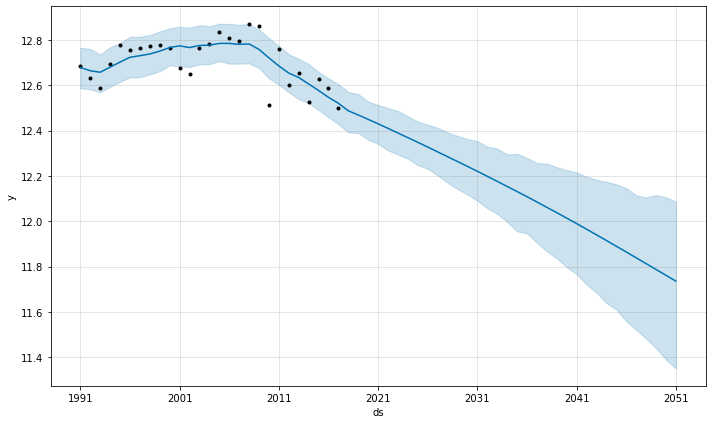

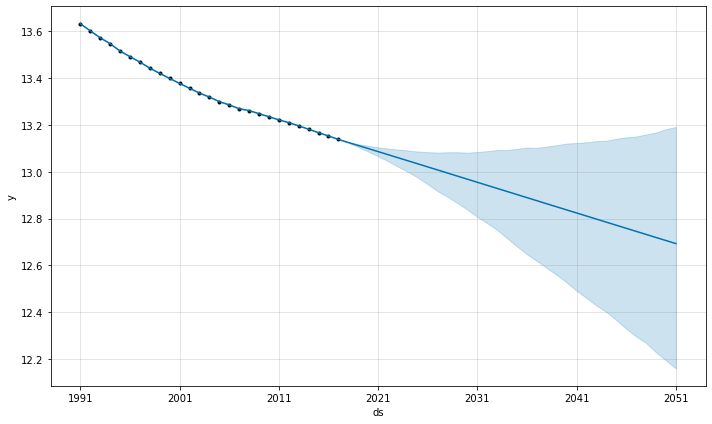

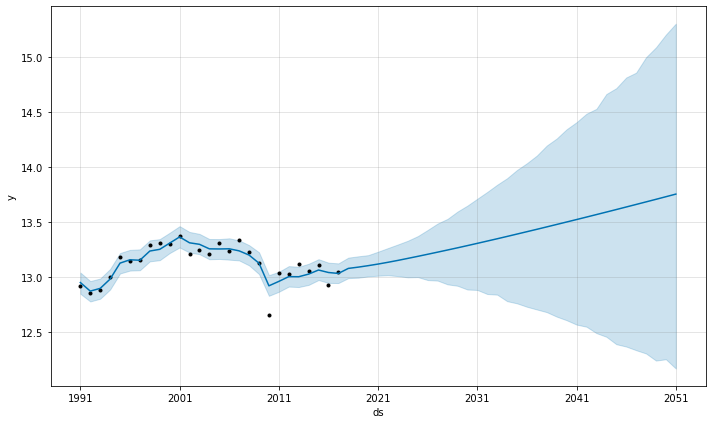

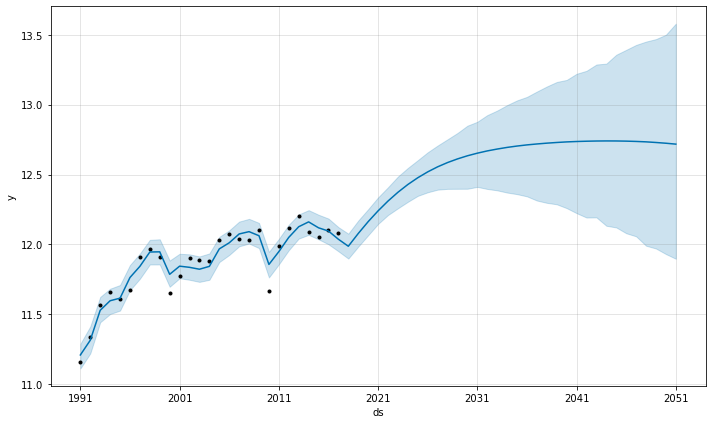

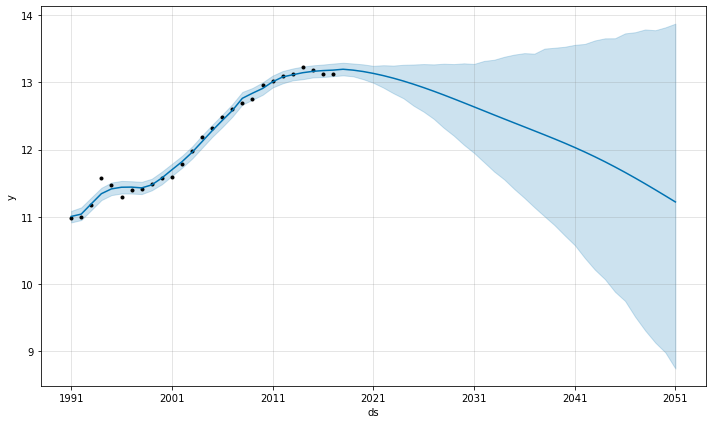

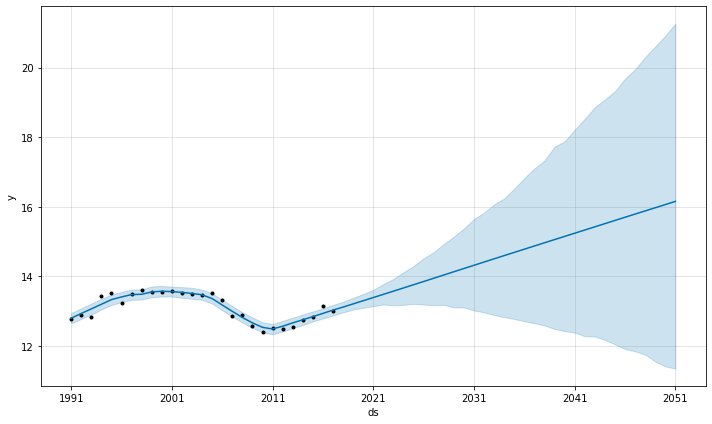

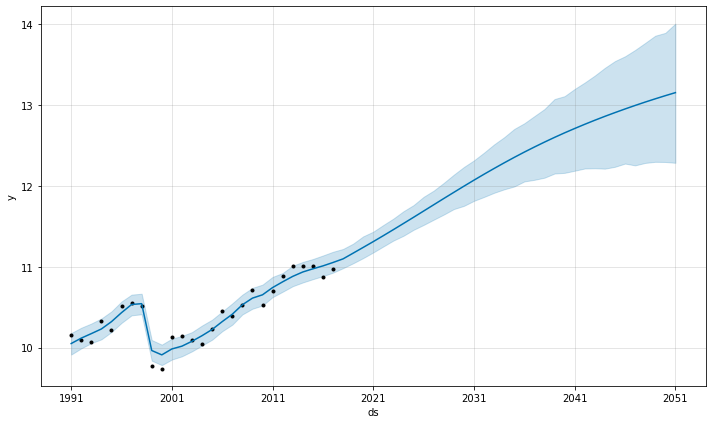

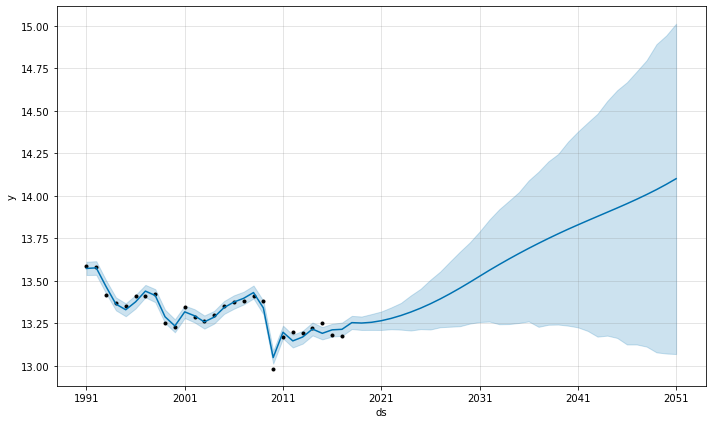

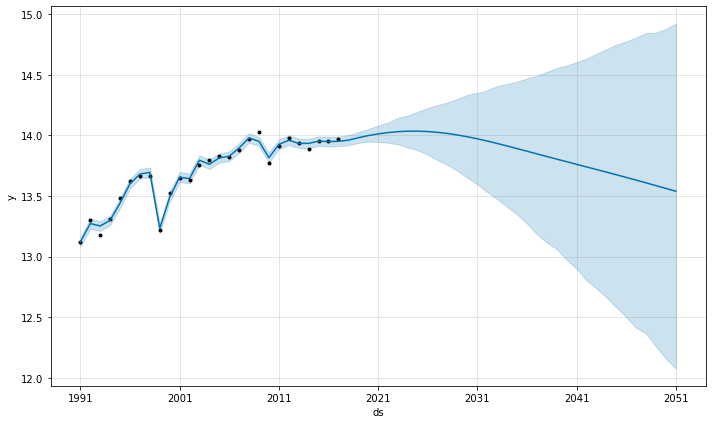

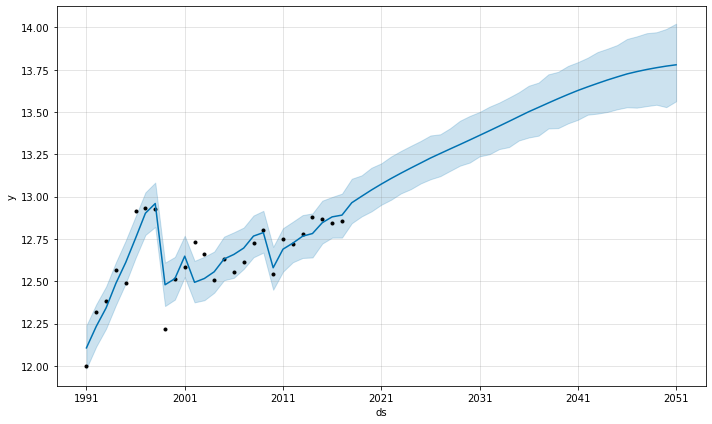

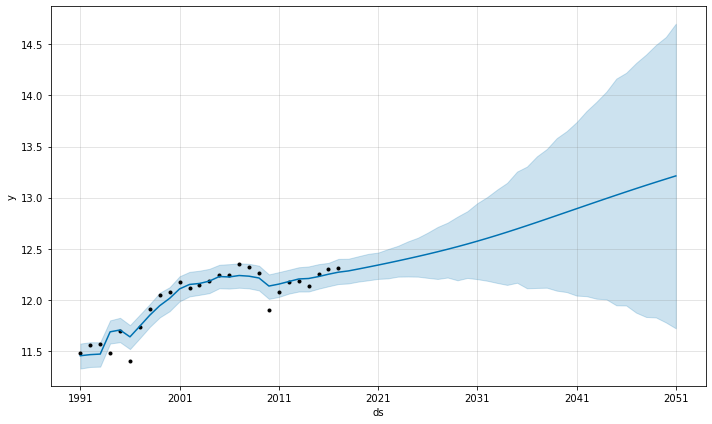

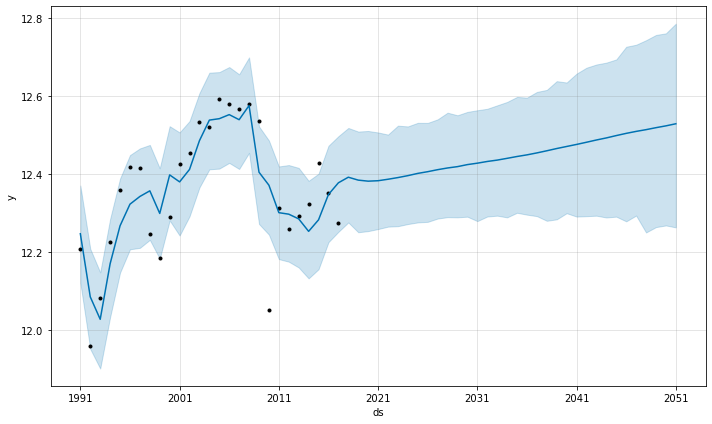

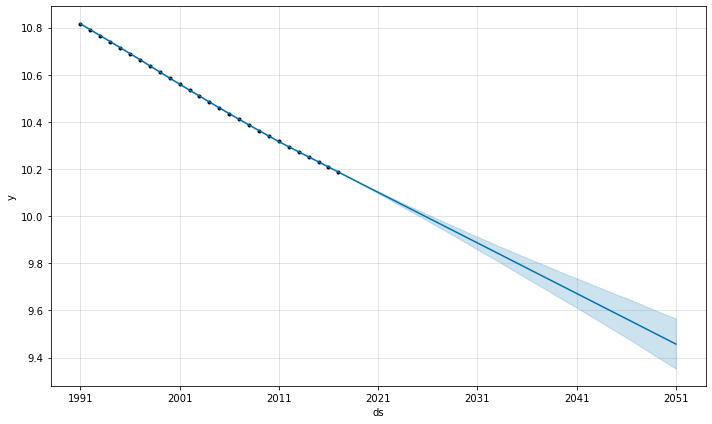

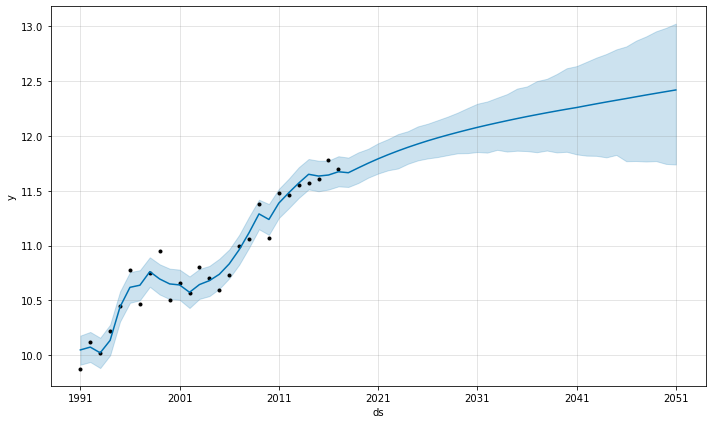

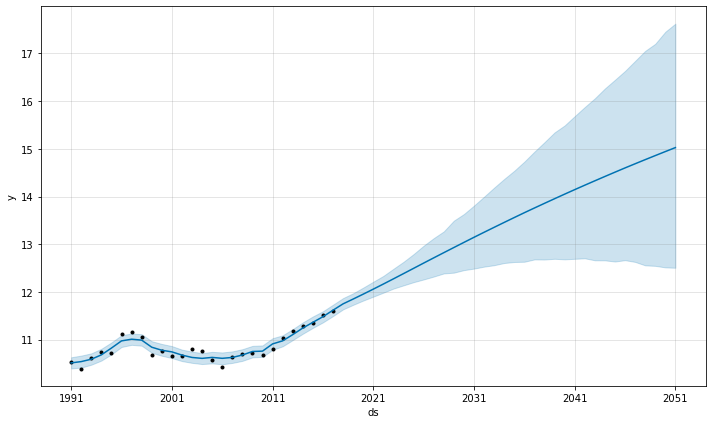

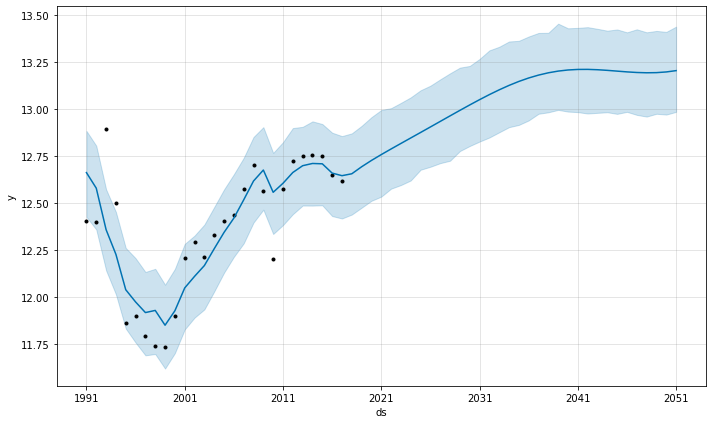

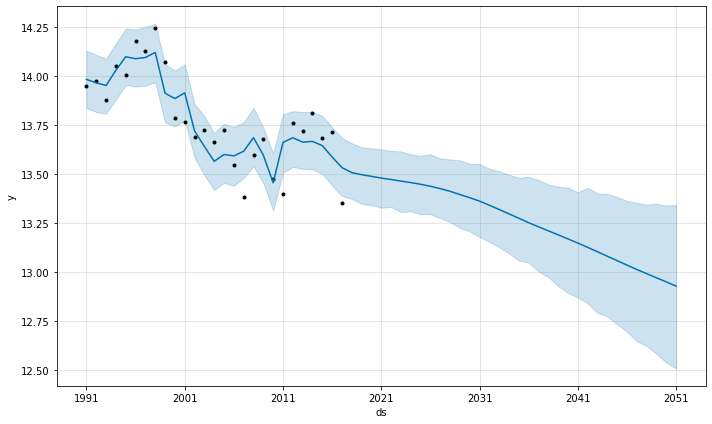

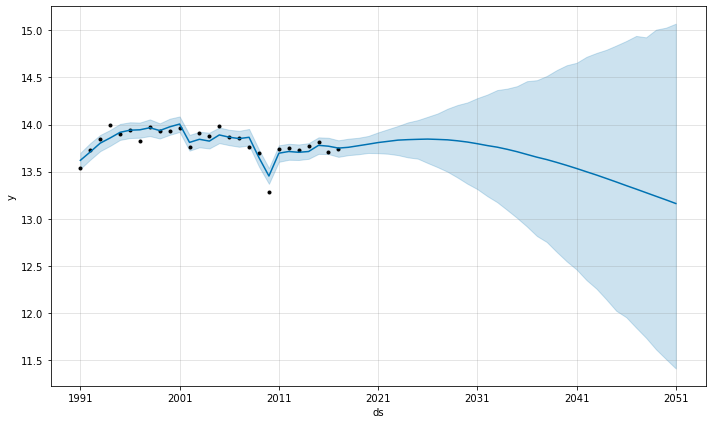

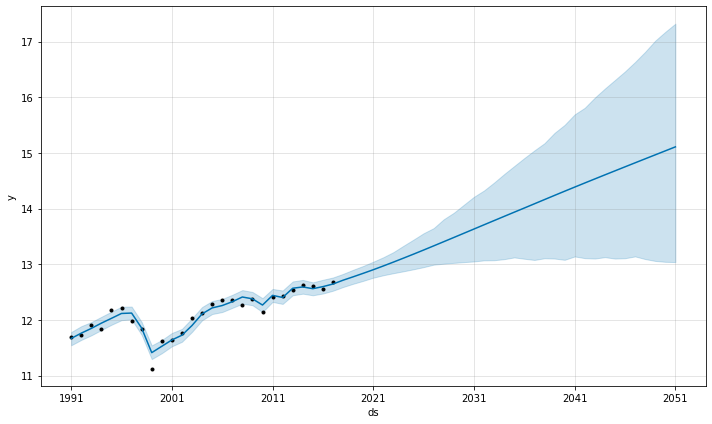

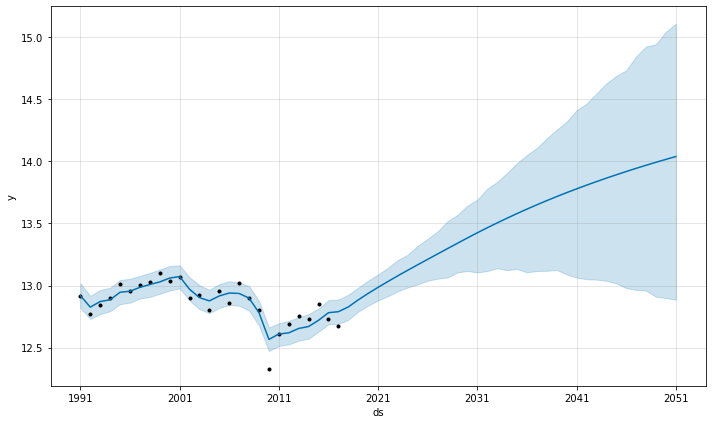

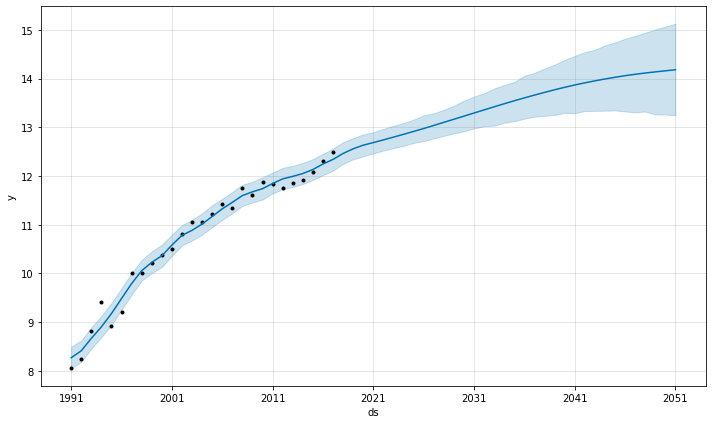

In [20]:
for economy,model in models.items():
    fig1 = model.plot(results.loc[economy])

In [ ]:
model